In [12]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader
from torchmetrics import Accuracy

import torchvision
import torchvision.transforms as transforms
import torchvision.transforms.functional as f

import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns

In [2]:
transform = transforms.Compose([transforms.ToTensor()])

train_batch_size = 50
test_batch_size = 20
train_set = torchvision.datasets.MNIST(root='./data/', train=True, download=True, transform=transform)
train_loader = DataLoader(train_set, batch_size=train_batch_size, shuffle=True, num_workers=2)

test_set = torchvision.datasets.MNIST(root='./data/', train=False, download=True, transform=transform)
test_loader = DataLoader(test_set, batch_size=test_batch_size, shuffle=False, num_workers=2)

In [3]:
torch.manual_seed(1)
plt.rcParams["savefig.bbox"] = 'tight'


def show(imgs):
    if not isinstance(imgs, list):
        imgs = [imgs]
    fix, axs = plt.subplots(ncols=len(imgs), squeeze=False)
    for i, img in enumerate(imgs):
        img = img.detach()
        img = f.to_pil_image(img)
        axs[0, i].imshow(np.asarray(img))
        axs[0, i].set(xticklabels=[], yticklabels=[], xticks=[], yticks=[])

In [4]:
class LeNet(nn.Module):
    def __init__(self, input_channels: int, num_classe: int):
        super().__init__()

        self.conv1 = nn.Conv2d(in_channels=input_channels, out_channels=6, kernel_size=5, padding=2)
        self.avg_pol1 = nn.AvgPool2d(kernel_size=2, stride=2)
        self.conv2 = nn.Conv2d(in_channels=6, out_channels=16, kernel_size=5)
        self.avg_pol2 = nn.AvgPool2d(kernel_size=2, stride=2)
        self.fc1 = nn.Linear(in_features=5*5*16, out_features=120)
        self.fc2 =  nn.Linear(in_features=120, out_features=84)
        self.fc3 = nn.Linear(in_features=84, out_features=num_classe)
        self.soft = nn.Softmax(dim=1)

    def forward(self, X):
        X = self.conv1(X)
        X = F.relu(X)

        X = self.avg_pol1(X)

        X = self.conv2(X)
        X = F.relu(X)

        X = self.avg_pol2(X)

        X = X.view(-1, 16*5*5) # flatten all conv features

        X = self.fc1(X)
        X = self.fc2(X)
        X = self.fc3(X)

        return self.soft(X)


In [5]:
# training
from torch.optim import RMSprop, Adam
from torch.nn import CrossEntropyLoss

model = LeNet(input_channels=1, num_classe=10)
optimizer = Adam(model.parameters(), lr=0.001)
cross_entropy = CrossEntropyLoss()


accuracy_list = []
train_accuracy = Accuracy(task="multiclass", num_classes=10)

epochs = 2
for _ in range(epochs):
    for i, (x_train, y_train) in enumerate(train_loader):
        y_pred = model(x_train)
        loss = cross_entropy(y_pred, y_train)
        accuracy_list.append(train_accuracy(y_pred, y_train))

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

C:\ProgramData\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
C:\ProgramData\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


Text(0.5, 1.0, 'Accuracy score')

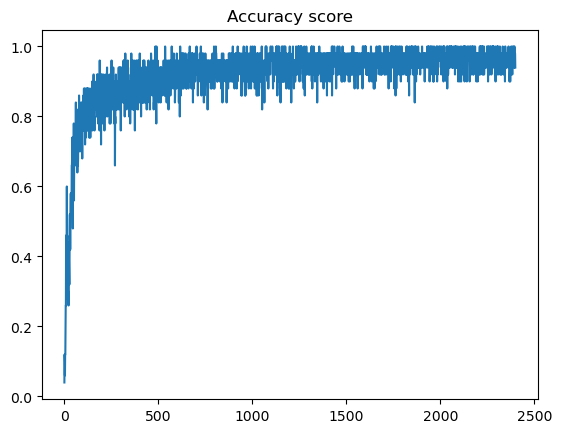

In [29]:
#plotting accuracy score for training
x = list(range(len(accuracy_list)))
y = [float(tensor) for tensor in accuracy_list]
sns.lineplot(x=x, y=y)
plt.title('Accuracy score')

In [6]:
# test
accuracy = Accuracy(task="multiclass", num_classes=10)

for i, (x_test, y_test) in enumerate(test_loader):
    y_pred = model(x_test)
    prediction = torch.argmax(y_pred, dim=1)
    real_value = y_test
    print('Real -> ', real_value)
    print('predicted ->', prediction)
    print(f'Accuracy of {i}th batch ->', accuracy(y_pred, y_test), '\n\n')

Real ->  tensor([7, 2, 1, 0, 4, 1, 4, 9, 5, 9, 0, 6, 9, 0, 1, 5, 9, 7, 3, 4])
predicted -> tensor([7, 2, 1, 0, 4, 1, 4, 9, 5, 9, 0, 6, 9, 0, 1, 5, 9, 7, 3, 4])
Accuracy of 0th batch -> tensor(1.) 


Real ->  tensor([9, 6, 6, 5, 4, 0, 7, 4, 0, 1, 3, 1, 3, 4, 7, 2, 7, 1, 2, 1])
predicted -> tensor([9, 6, 6, 5, 4, 0, 7, 4, 0, 1, 3, 1, 3, 4, 7, 2, 7, 1, 2, 1])
Accuracy of 1th batch -> tensor(1.) 


Real ->  tensor([1, 7, 4, 2, 3, 5, 1, 2, 4, 4, 6, 3, 5, 5, 6, 0, 4, 1, 9, 5])
predicted -> tensor([1, 7, 4, 2, 3, 5, 1, 2, 4, 4, 6, 3, 5, 5, 6, 0, 4, 1, 9, 5])
Accuracy of 2th batch -> tensor(1.) 


Real ->  tensor([7, 8, 9, 3, 7, 4, 6, 4, 3, 0, 7, 0, 2, 9, 1, 7, 3, 2, 9, 7])
predicted -> tensor([7, 8, 9, 3, 7, 4, 6, 4, 3, 0, 7, 0, 2, 9, 1, 7, 3, 2, 9, 7])
Accuracy of 3th batch -> tensor(1.) 


Real ->  tensor([7, 6, 2, 7, 8, 4, 7, 3, 6, 1, 3, 6, 9, 3, 1, 4, 1, 7, 6, 9])
predicted -> tensor([7, 6, 2, 7, 8, 4, 7, 3, 6, 1, 3, 6, 9, 3, 1, 4, 3, 7, 6, 9])
Accuracy of 4th batch -> tensor(0.9500) 


R

In [7]:
# training on GPU
device = 'cuda' if torch.cuda.is_available() else 'cpu'

model = LeNet(input_channels=1, num_classe=10)
optimizer = Adam(model.parameters(), lr=0.001)
cross_entropy = CrossEntropyLoss()

model = model.to(device)
cross_entropy = cross_entropy.to(device)

epochs = 2
for _ in range(epochs):
    for i, (x_train, y_train) in enumerate(train_loader):
        x_train = x_train.to(device)
        y_train = y_train.to(device)

        y_pred = model(x_train)
        loss = cross_entropy(y_pred, y_train)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

In [8]:
#summary of LeNet
from torchsummary import summary
summary(model, (1, 28, 28), batch_size=1)

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1             [1, 6, 28, 28]             156
         AvgPool2d-2             [1, 6, 14, 14]               0
            Conv2d-3            [1, 16, 10, 10]           2,416
         AvgPool2d-4              [1, 16, 5, 5]               0
            Linear-5                   [1, 120]          48,120
            Linear-6                    [1, 84]          10,164
            Linear-7                    [1, 10]             850
           Softmax-8                    [1, 10]               0
Total params: 61,706
Trainable params: 61,706
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.00
Forward/backward pass size (MB): 0.06
Params size (MB): 0.24
Estimated Total Size (MB): 0.30
----------------------------------------------------------------
